# Experiment 15: Implementació de la xarxa neuronal Double-U-Net per a la segmentació de ferides (entrenament amb 35 èpoques)

Carregarem els paquets necessaris

In [4]:
import cv2
import glob
import numpy 
import os
import skimage

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from cnn_architectures.architectures.models.double_unet.double_unet import DoubleUNet
from matplotlib import pyplot as plt
from numpy.random import seed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend 
from tensorflow.keras.optimizers import *
from typing import Tuple, List

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
seed(1)

## Lectura del *Redscar Dataset* i implementació del generador

Les imatges que s'empraran per a fer l'entrenament les anirem carregant a mesura que la xarxa les demani, per evitar carregar tot el dataset en memòria. Primer de tot, establirem la ruta del dataset.

In [2]:
REDSCAR_DATASET = "/home/marc/UIB_EXPERIMENTS/REDSCAR"
REDSCAR_DATASET_TRAIN = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "train")
REDSCAR_DATASET_TEST = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "test")

In [3]:
def neural_network_generator(img_path: str, gt_path: str, size: Tuple[int, int], batch_size: int):
    images = sorted(glob.glob(img_path))
    masks = sorted(glob.glob(gt_path))
    
    assert len(images) == len(masks), "The number of images and masks to be used must match."
    
    batch_img = []
    batch_mask = []
    idx = 1
    
    while(True):
        path_img = images[idx % len(images)]
        path_mask = masks[idx % len(images)]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
            
        batch_img.append(img)
        batch_mask.append(numpy.dstack((mask, mask)))
        
        if (idx%(batch_size) == 0) and idx != 0:            
            batch_img = numpy.array(batch_img)
            batch_mask = numpy.array(batch_mask)
            
            yield batch_img, batch_mask
            
            batch_img = []
            batch_mask = []
        idx += 1
        
def validation_generator(img_path: str, gt_path: str, size: Tuple[int, int]):
    images_names = sorted(glob.glob(img_path))
    masks_names = sorted(glob.glob(gt_path))
    
    images = []
    masks = []
    
    for image_idx in range(len(images_names)):
        path_img = images_names[image_idx]
        path_mask = masks_names[image_idx]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
        
        images.append(img)
        masks.append(numpy.dstack((mask, mask)))
    
    return (numpy.array(images), numpy.array(masks))

In [4]:
IMAGES_TEST, GT_TEST = validation_generator(img_path=REDSCAR_DATASET_TEST+'/IMAGES/*.png', 
                       gt_path=REDSCAR_DATASET_TEST+'/GT_WOUND_MASK/*.png', 
                       size=(256, 256))

(5, 256, 256, 3) (5, 256, 256, 2)


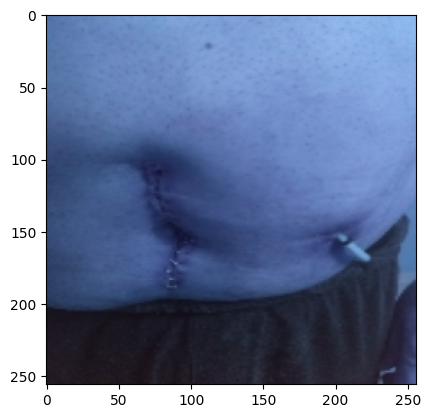

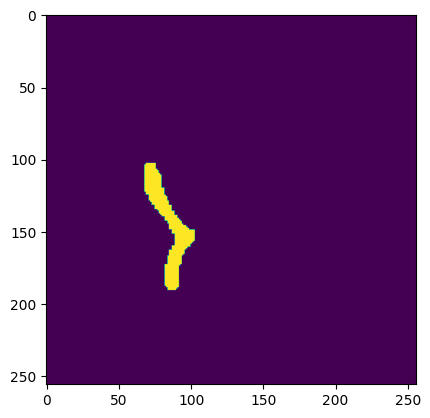

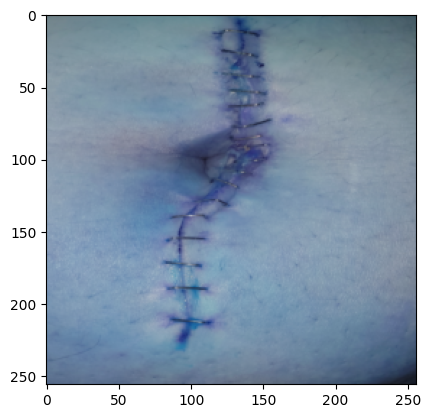

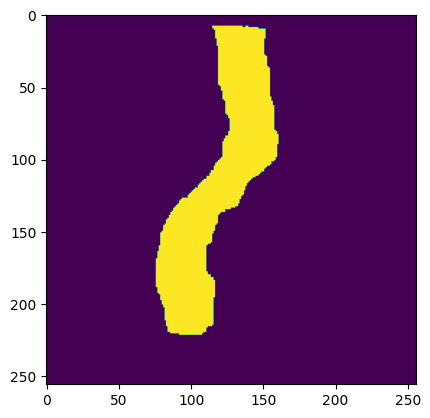

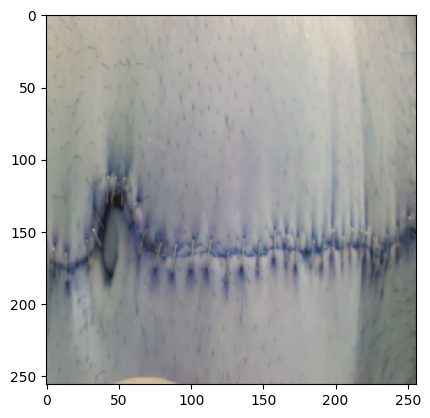

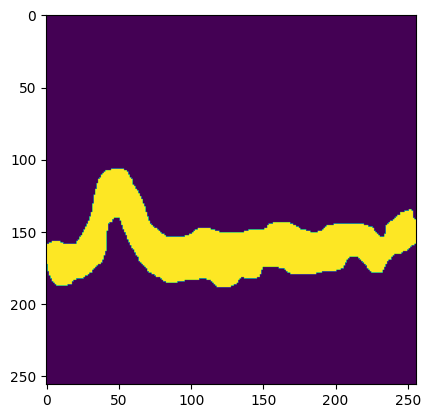

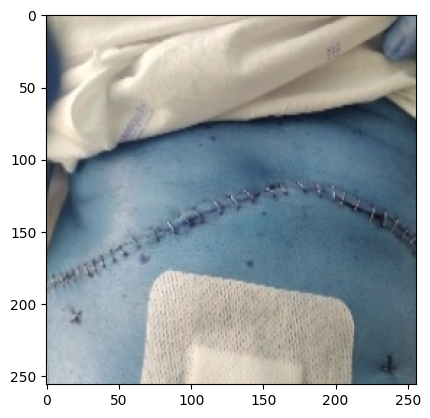

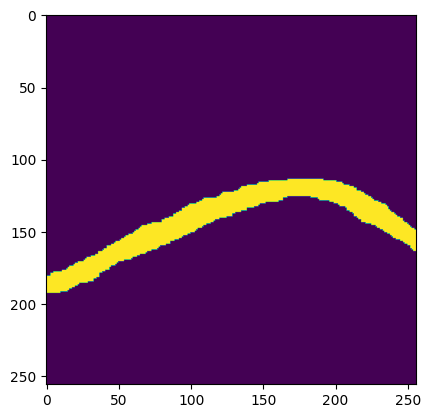

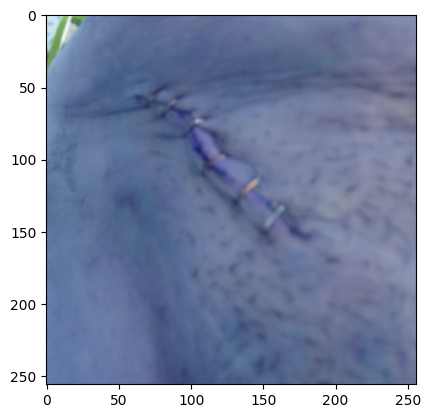

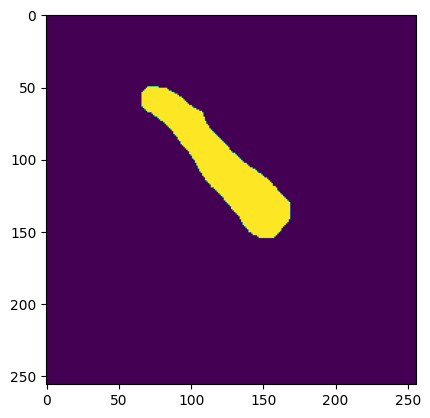

In [5]:
BATCH_SIZE = 5
for image_batch, mask_batch in neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
                                                        gt_path=REDSCAR_DATASET_TRAIN+'/GT_WOUND_MASK/*.png', 
                                                        size=(256, 256), 
                                                        batch_size=BATCH_SIZE):
    print(image_batch.shape, mask_batch.shape)
    for i in range(0, BATCH_SIZE):
        plt.imshow(image_batch[i,:,:,:])
        plt.show()
        plt.imshow(mask_batch[i,:,:,0])
        plt.show()
    break

## Implementació de la Double-U-Net:

Aquesta xarxa fou presentada a *DoubleU-Net: A Deep Convolutional Neural
Network for Medical Image Segmentation*. La seva estructura es pot veure a la següent imatge:


In [6]:
def build_double_unet(input_shape=Tuple[int,int,int]):
    inputs = tf.keras.layers.Input(input_shape) 
    

double_unet = DoubleUNet(input_size=(256,256,3))
double_unet.build()

double_unet.summary()
# Aquest objecte és una classe de Python, de la llibreria cnn_architectures. 
# Si volem accedir al model de Keras, basta fer double_unet.model

2024-06-09 20:11:31.446372: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-06-09 20:11:31.466641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2024-06-09 20:11:31.466671: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2024-06-09 20:11:31.467942: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-06-09 20:11:31.469032: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2024-06-09 20:11:31.469225: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_image[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

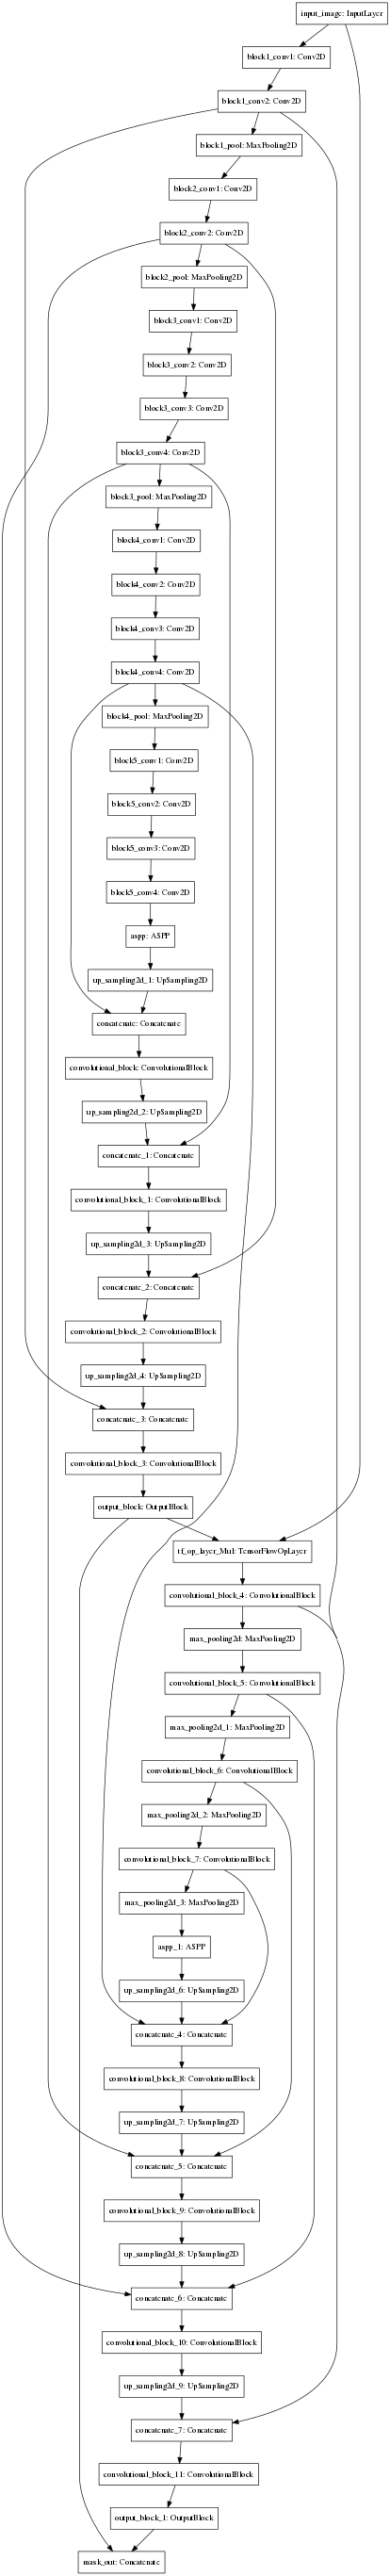

In [6]:
tf.keras.utils.plot_model(
    double_unet.model,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
)

## Entrenament de la Double UNet


Ja ho tenim quasi a punt per a fer l'entrenament. Només ens queda definir la funció de pèrdua. Emprarem el coeficient de dice atès que és una mètrica emprada usualment en aquests casos.

In [5]:
def dice(y_true, y_pred):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2.* intersection+1) / (backend.sum(y_true_f) + backend.sum(y_pred_f)+1 )

def dice_loss(y_true, y_pred):
    return 1-dice(y_true, y_pred)

In [8]:
double_unet.compile(loss_func=dice_loss, metrics=[dice, 'binary_accuracy']) 

In [9]:
BATCH_SIZE = 5
TOTAL_IMAGES = 275
STEPS_PER_EPOCH = TOTAL_IMAGES // BATCH_SIZE 
EPOCHS = 35

reduceLROnPlat = ReduceLROnPlateau(monitor='dice', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', cooldown=2, min_lr=1e-7)
early = EarlyStopping(monitor="dice",
                      mode="max",
                      patience=8)
CALLBACKS = [early, reduceLROnPlat]

TRAIN_GENERATOR = neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
                                           gt_path=REDSCAR_DATASET_TRAIN+'/GT_WOUND_MASK/*.png', 
                                           size=(256, 256), 
                                           batch_size=BATCH_SIZE)

In [10]:
double_unet.train(train_generator=TRAIN_GENERATOR,
                                epochs=EPOCHS,
                                steps_per_epoch=STEPS_PER_EPOCH,
                                validation_steps=2,
                                callbacks=CALLBACKS,
                                validation_data=(IMAGES_TEST, GT_TEST))

Epoch 1/35


2024-04-06 12:46:28.533315: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-04-06 12:46:28.689321: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


55/55 [==============================] - 328s 6s/step - loss: 0.8164 - dice: 0.1836 - binary_accuracy: 0.7607 - val_loss: 0.8288 - val_dice: 0.1711 - val_binary_accuracy: 0.4966
Epoch 2/35
55/55 [==============================] - 318s 6s/step - loss: 0.7488 - dice: 0.2512 - binary_accuracy: 0.8732 - val_loss: 0.7971 - val_dice: 0.2028 - val_binary_accuracy: 0.7713
Epoch 3/35
55/55 [==============================] - 316s 6s/step - loss: 0.7217 - dice: 0.2783 - binary_accuracy: 0.9191 - val_loss: 0.7766 - val_dice: 0.2232 - val_binary_accuracy: 0.8860
Epoch 4/35
55/55 [==============================] - 320s 6s/step - loss: 0.7024 - dice: 0.2976 - binary_accuracy: 0.9457 - val_loss: 0.7499 - val_dice: 0.2499 - val_binary_accuracy: 0.9386
Epoch 5/35
55/55 [==============================] - 320s 6s/step - loss: 0.6903 - dice: 0.3097 - binary_accuracy: 0.9532 - val_loss: 0.7353 - val_dice: 0.2645 - val_binary_accuracy: 0.9665
Epoch 6/35
55/55 [==============================] - 321s 6s/step -

No basta només amb entrenar la xarxa. També hem de poder avaluar la qualitat de l'entrenament. Per això, la variable `training_history` de la cel·la anterior té aquesta informació.

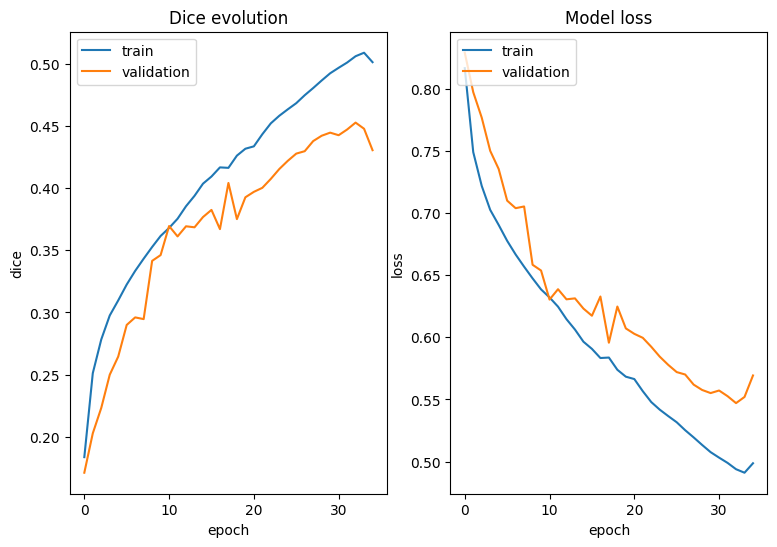

In [11]:
plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.plot(double_unet.history.history['dice'])
plt.plot(double_unet.history.history['val_dice'])
plt.title('Dice evolution')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(double_unet.history.history['loss'])
plt.plot(double_unet.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15'
plt.savefig(EXPERIMENT_PATH+f'/doubleunet_ferides_rendiment.png')

**Molt important també**. Podem haver fet l'entrenament, però si en algun moment volem fer una altra prova naturalment tornar a entrenar la xarxa no és una opció, perquè perdem temps de computació en una feina que prèviament ja hem fet. Per això, podem guardar el model en un fitxer, i recuperar-lo posteriorment per a fer les prediccions que puguin fer falta. L'extensió del fitxer **sempre** ha de ser `.h5`.

In [12]:
EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15'
double_unet.save(os.path.join(EXPERIMENT_PATH, "doubleunet_ferides.h5"))

Si ara volem recuperar el model, ho farem de la següent manera. L'estat de la xarxa és idèndic a quan la vàrem guardar.

In [6]:
EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15'
from tensorflow.keras.models import load_model
from cnn_architectures.architectures.models.double_unet.layers import ASPP, ConvolutionalBlock, OutputBlock


loaded_model = load_model(os.path.join(EXPERIMENT_PATH, "doubleunet_ferides.h5"), 
                          custom_objects={'dice_loss': dice_loss, 
                                          'dice': dice,
                                          'ASPP': ASPP,
                                          'ConvolutionalBlock': ConvolutionalBlock, 
                                          'OutputBlock': OutputBlock})

2024-07-06 00:50:25.078817: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-07-06 00:50:25.084519: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-06 00:50:25.084550: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: T-Series
2024-07-06 00:50:25.084558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: T-Series
2024-07-06 00:50:25.084642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.33.1
2024-07-06 00:50:25.084672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.33.1
2024-07-06 00:50:25.084678: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.33.1
2024-07-06 00:50:25.084963: I tensorflow/core/platform/cpu_feature

## Prediccions amb la Double-UNet 

Fins ara hem implementat la Double-UNet , l'hem entrenat i hem guardat els pesos a un fitxer per a poder fer futures prediccions. Això és el que pretenem fer en aquesta secció: passar-li una imatge a la Double-UNet, i que ens faci la predicció. 

És important observar un fet: quan li passam imatges amb el generador, li estem donant amb una certa mida, i la xarxa ens torna les imatges també amb una certa mida de sortida. Però clar, no totes les imatges del dataset tenen la mateixa mida, ni tampoc tenen la mateixa mida $256\times 256$ que li imposam a la xarxa. Per aquest motiu, és important establir un criteri. Com que les màscares ens determinen la posició exacta de l'objecte, farem el següent:

1. Donada una imatge sobre la que volem fer la predicció, canviar la seva mida a la dimensió d'entrada de la xarxa.
2. Calcular la predicció del model, que ens tornarà una imatge en la dimensió de sortida del mateix. Aquesta sortida serà, **en el cas de la Double-UNet**, una imatge amb entrades dins l'interval $[0,1]$, que podem interpretar com una imatge en escala de grisos.
3. Redimensionar aquesta sortida amb les dimensions de la imatge en qüestió.
4. Binaritzar el resultat de la passa anterior.
5. Comparar amb la màscara.

Un dubte que pot sorgir és si les passes 3 i 4 es poden permutar. La resposta és que no. Si primer binaritzam, quan facem el canvi d'escala posterior la imatge resultant **no** és, en general, binària. Hem de pensar que fer un canvi d'escala aplica per darrere una sèrie de tècniques d'interpolació, que poden donar lloc a imatges en escala de grisos, que no són comparables a la passa 4 amb la màscara final.

In [7]:
def predict_image(model: tf.keras.models.Model, model_input: Tuple[int, int], image: numpy.ndarray, binary_threshold: float=0.5):
    resized_image = skimage.transform.resize(image, (model_input[0], model_input[1], 3)) #Passa 1
    prediction_raw = model.predict(numpy.array([resized_image])) # Passa 2
    
    # Passa 3
    prediction = prediction_raw[0][:,:,1]
    prediction_resized = skimage.transform.resize(prediction, (image.shape[0], image.shape[1]))
    prediction_binary_bool = prediction_resized >= binary_threshold
    prediction_binary = 255*prediction_binary_bool
    
    return prediction_binary

In [26]:
test_image_name = "BZuyAY51Mf43RKhhnsromiPaN_infection=0_capture=0_resolution=1.png"
original_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "IMAGES", test_image_name))
gt_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "GT_WOUND_MASK", test_image_name), 0)

#result = predict_image(model=double_unet, model_input=(256, 256), image=original_image)
# En lloc de double_unet també podem passar loaded_model. Són el mateix model i per tant fan la mateixa predicció.
prediction = predict_image(model=loaded_model, model_input=(256, 256), image=original_image)

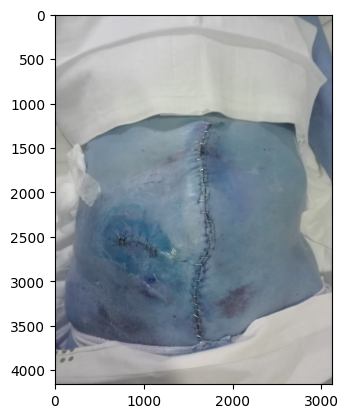

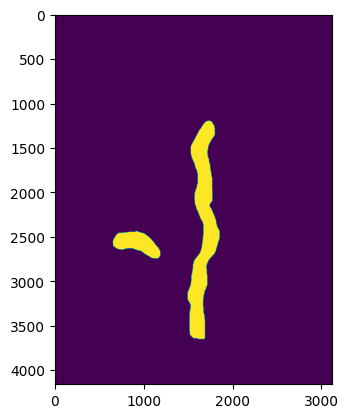

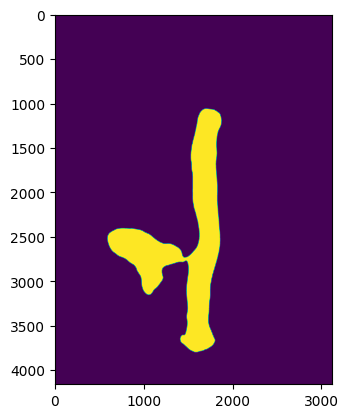

In [27]:
plt.imshow(original_image)
plt.show()

plt.imshow(gt_image)
plt.show()

plt.imshow(prediction)
plt.show()


Ara implementarem dues funcions que reben per paràmetres la gt i la predicció i ens retornen la mètrica: la dice i la jaccard.

In [28]:
 def metriques_absolutes(gt_image, prediction):
    (n,m) = numpy.shape(gt_image)  
    
    if (n,m) != numpy.shape(prediction): # comprovació que les mides de la imatge de la predicció i la de la gt coincideixen
        return []
    
    [tp,fn,fp,tn] = [0,0,0,0] # si les mides coincideixen, calcularem les mètriques absolutes
    for i in range(n):
        for j in range(m):
            if gt_image[i][j]==255 and prediction[i][j]==255: 
                tp += 1
            elif gt_image[i][j]==255 and prediction[i][j]==0:
                fn += 1
            elif gt_image[i][j]==0 and prediction[i][j]==255:
                fp += 1
            elif gt_image[i][j]==0 and prediction[i][j]==0:
                tn += 1
                    
    return [tp,fn,fp,tn]

In [29]:
def dice_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)  
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de dice
    if (2*tp + fp + fn) == 0: #això voldria dir que tots el coefs. són TN i, per tant, ho fa bé
        dice = 1
    else:
        dice = 2*tp/(2*tp + fp + fn)
    
    return [tp,fn,fp,tn,dice]

In [30]:
def jaccard_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de jaccard
    if (tp + fp + fn) == 0: #com abans, la predicció és bona
        jaccard = 1
    else:
        jaccard = tp/(tp + fp + fn)
    
    return [tp,fn,fp,tn,jaccard]

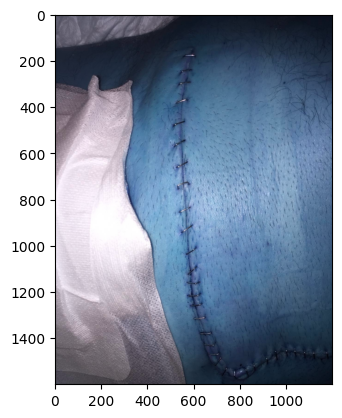

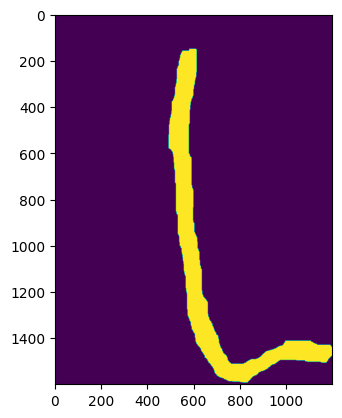

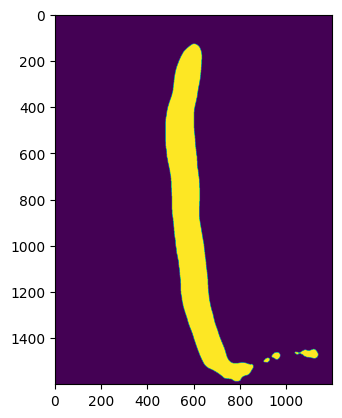

[121388, 25600, 52365, 1720647, 0.75692225191042]


In [31]:
# PROVA SI FUNCIONA LA CALCULADORA DE MÈTRIQUES ABSOLUTES
imatges_train = os.path.join(REDSCAR_DATASET_TRAIN, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TRAIN, "GT_WOUND_MASK")
    
nom_imatge = '3XOKKCioHUZbjDr5S21pGwHU6_infection=0_capture=1_resolution=1.png' #imatge amb 0s i 1s 

imatge = cv2.imread(os.path.join(imatges_train, nom_imatge), 1) # en color
gt = cv2.imread(os.path.join(gt_train, nom_imatge), 0) # escala de grisos

plt.imshow(imatge)
plt.show()

plt.imshow(gt)
plt.show()
#feim la predicció
#prediccio = predict_image(model=double_unet, model_input=(256, 256), image=imatge)
prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
plt.imshow(prediccio)
plt.show()

print(dice_coefficient(gt, prediccio))

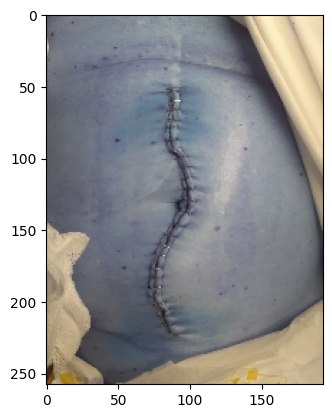

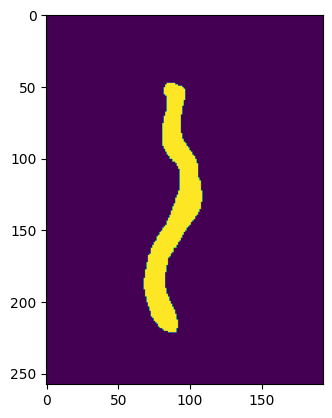

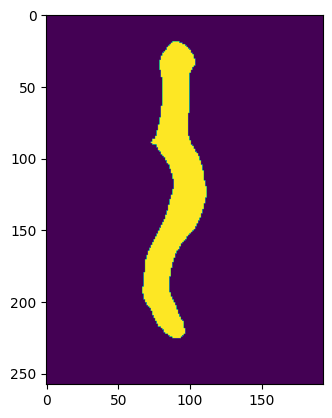

[2641, 12, 1661, 45480, 0.7594536304816679]


In [32]:
# PROVA 2 SI FUNCIONA LA CALCULADORA DE MÈTRIQUES ABSOLUTES
imatges_train = os.path.join(REDSCAR_DATASET_TEST, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TEST, "GT_WOUND_MASK")
    
nom_imatge = 'zU1LXaMl34s64fxf22resmwfs_infection=0_capture=1_resolution=0.png' 

imatge = cv2.imread(os.path.join(imatges_train, nom_imatge), 1) # en color
gt = cv2.imread(os.path.join(gt_train, nom_imatge), 0) # escala de grisos

plt.imshow(imatge)
plt.show()

plt.imshow(gt)
plt.show()
#feim la predicció
#prediccio = predict_image(model=double_unet, model_input=(256, 256), image=imatge)
prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
plt.imshow(prediccio)
plt.show()

print(dice_coefficient(gt, prediccio))

Ara avaluarem les imatges de train amb ambdues mètriques:

In [33]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_train = os.path.join(REDSCAR_DATASET_TRAIN, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TRAIN, "GT_WOUND_MASK")

for nom_imatge in os.listdir(imatges_train): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_train,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_train,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = dice/(2-dice) #jaccard_coefficient(gt, prediccio)[-1], per a fer més via usarem la relació entre jaccard i dice (j = s/(2-s))
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
doublenet_ferides_train = pd.DataFrame({'NOM': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/doubleunet_ferides_train.csv'
doublenet_ferides_train.to_csv(RESULTATS_PATH, index=False)


Farem el mateix amb les imatges de test:

In [34]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_test = os.path.join(REDSCAR_DATASET_TEST, "IMAGES")
gt_test = os.path.join(REDSCAR_DATASET_TEST, "GT_WOUND_MASK")

for nom_imatge in os.listdir(imatges_test): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_test,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_test,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=loaded_model, model_input=(256, 256), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = dice/(2-dice) #jaccard_coefficient(gt, prediccio)[-1], per a fer més via usarem la relació entre jaccard i dice (j = s/(2-s))
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
doubleunet_ferides_test = pd.DataFrame({'NOM': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/doubleunet_ferides_test.csv'
doubleunet_ferides_test.to_csv(RESULTATS_PATH, index=False)


## Algunes prediccions:
Per a poder veure com de bé ho fa la xarxa Double-UNet, guardarem algunes prediccions. En aquest cas, seleccionarem 15 imatges del DS (les 10 millors segons la mètrica DICE i les 5 pitjors) i en guardarem a la carpeta 'Resultats' 

In [6]:
# carregam el data frame de test:
import pandas as pd
df = pd.read_csv('/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/doubleunet_ferides_test.csv')
# l'ordenam en funció del coeficient dice
df_sorted = df.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar
# guardarem també a un fitxer els noms de les imatges i els coeficients
print(df_sorted)

                                                   NOM      DICE   JACCARD  \
0    ZhGDx15ItouVKfJmOtpmwoFoi_infection=0_capture=...  0.932166  0.872951   
1    cPYhmZcbJwrTse9ivAwswH3aR_infection=0_capture=...  0.922011  0.855307   
2    3DCYh9WC6Es11DJ1c3HC07mzZ_infection=0_capture=...  0.912939  0.839823   
3    B130dg1MOeVf1euZ7ScuyO7JQ_infection=0_capture=...  0.910658  0.835971   
4    j8pTkNIWfF6QcgTYUeCuV01my_infection=0_capture=...  0.908052  0.831589   
..                                                 ...       ...       ...   
114  YH30nPmh3tokV3aNsPNrFNtpt_infection=0_capture=...  0.346902  0.209850   
115  Nnq9VMIujxGziNrbm89UxZ6SK_infection=0_capture=...  0.336112  0.202004   
116  YzLNpYW33lmFgkqNRUKgIzj1J_infection=0_capture=...  0.283372  0.165075   
117  djnIcpMtGUmA2PAxIYTDpdD9y_infection=0_capture=...  0.278814  0.161990   
118  fEMdP896R7Ns2a6mtbb0uGbpT_infection=0_capture=...  0.131387  0.070312   

         TP      FN       FP       TN  
0    537935   28442    

Ara implementarem diverses funcions per a obtenir visualitzacions dels resultats

In [11]:
# funció ppal que cridarà a les altres:
def visualitzacions(model, noms_imatges: list, ruta_imatges: str, ruta_gt: str, input_size: int, ruta_guardar: str, titol: str, qualitat: int):
    k = 1 
    for nom in noms_imatges:
        # carregam la imatge, la gt i feim la predicció
        imatge = cv2.imread(os.path.join(ruta_imatges, nom), 1) # en color
        gt = cv2.imread(os.path.join(ruta_gt, nom), 0) # escala de grisos
        prediccio = predict_image(model=loaded_model, model_input=(input_size, input_size), image=imatge)
        
        # cridam a la funció que dibuixa la prediccio sobre la imatge original
        res1 = mascara(imatge,prediccio)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_mascara.png", res1)
        
        # cridam a la funció que dibuixa els contorns de la predicció i de la gt sobre la imatge original
        res2 = contorns(imatge, prediccio, gt, qualitat)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_contorns.png", res2)
        plt.imshow(res2)
        plt.show()
        
        k += 1

In [12]:
# funció auxiliar que dibuixa la predicció sobre la imatge original:
def mascara(imatge, prediccio):
    mascara = imatge.copy()
    for i in range(imatge.shape[0]):
        for j in range(imatge.shape[1]):
            if prediccio[i, j] > 0:  
                mascara[i, j] = [107,183,189]  # Paint in yellow
    return mascara    

In [8]:
# funció auxiliar que dibuixa els contorns de la gt i de la prediccio sobre la imatge original:
# color gt = green; color prediccio = red
def contorns(imatge, prediccio, gt, qualitat):
    resultat = imatge.copy()
    # PREDICCIO
    # find contours with hierarchy
    contours, hier = cv2.findContours(prediccio.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                                                # how the contours are retrieved and organized, contour approximation method
    # Define sufficient enough colors for blobs (taques)
    colors = [(0, 255, 0), (0, 0, 255)] # green and red (BGR format)
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 5) #pintam la predicció de vermell
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 1) #pintam la predicció de vermell

        
    # GT
    # find contours with hierarchy
    contours, hier = cv2.findContours(gt.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                                                # how the contours are retrieved and organized, contour approximation method
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 5) #pintam la gt de verd
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 1) #pintam la gt de verd
    return resultat

Ara sí, anem a guardar els resultats:

## Filtratge 1: millors i pitjors imatges de bona resolució

In [14]:
# carregam el data frame de test:
#import pandas as pd
df = pd.read_csv('/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/doubleunet_ferides_test.csv')

# filtram les imatges d'alta resolució -> df1
df1 = df[df['NOM'].str.endswith('resolution=1.png')]

# l'ordenam en funció del coeficient dice
df1_sorted = df1.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar
# guardarem també a un fitxer els noms de les imatges i els coeficients
print(df1_sorted)

                                                  NOM      DICE   JACCARD  \
0   ZhGDx15ItouVKfJmOtpmwoFoi_infection=0_capture=...  0.932166  0.872951   
1   3DCYh9WC6Es11DJ1c3HC07mzZ_infection=0_capture=...  0.912939  0.839823   
2   j8pTkNIWfF6QcgTYUeCuV01my_infection=0_capture=...  0.908052  0.831589   
3   8YbCiWvObpgknN0QknClXksg6_infection=1_capture=...  0.900733  0.819394   
4   OsrZmLCXyemFXvMtvd80E3yk2_infection=0_capture=...  0.899257  0.816954   
..                                                ...       ...       ...   
65  Hm7gwnrmEuFw7ZhMyAfC6ouIM_infection=0_capture=...  0.447560  0.288295   
66  ZDRKTfK2SzrWV2k9sHBgW79AH_infection=0_capture=...  0.441310  0.283129   
67  P8RhAHQY5StAbedV1qrwOXFu0_infection=0_capture=...  0.423413  0.268563   
68  YzLNpYW33lmFgkqNRUKgIzj1J_infection=0_capture=...  0.283372  0.165075   
69  djnIcpMtGUmA2PAxIYTDpdD9y_infection=0_capture=...  0.278814  0.161990   

         TP      FN       FP        TN  
0    537935   28442    49849   896

In [15]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df1_sorted.loc[i,"NOM"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df1_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df1_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df1_sorted.loc[i,"NOM"]
    dice_value = df1_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_doubleunet_alta = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/doubleunet_ferides_resultats_alta.csv'
resultats_doubleunet_alta.to_csv(RESULTATS_PATH, index=False)


['ZhGDx15ItouVKfJmOtpmwoFoi_infection=0_capture=1_resolution=1.png', '3DCYh9WC6Es11DJ1c3HC07mzZ_infection=0_capture=1_resolution=1.png', 'j8pTkNIWfF6QcgTYUeCuV01my_infection=0_capture=0_resolution=1.png', '8YbCiWvObpgknN0QknClXksg6_infection=1_capture=0_resolution=1.png', 'OsrZmLCXyemFXvMtvd80E3yk2_infection=0_capture=0_resolution=1.png', 'TBNtKYTcLfWmsAq7HPMBqhoIP_infection=0_capture=0_resolution=1.png', '51LdARGjh4OcfN7hVSduVPBiI_infection=0_capture=1_resolution=1.png', 'FSnf366Tr9kX4cYZJRVzTUfwD_infection=0_capture=0_resolution=1.png', 'Rnod1BInWHCTgdRWAltq1LejC_infection=0_capture=0_resolution=1.png', '3UvxqIcSqGcRtnqKiN9CCk2mQ_infection=0_capture=1_resolution=1.png']
['ZhGDx15ItouVKfJmOtpmwoFoi_infection=0_capture=1_resolution=1.png', '3DCYh9WC6Es11DJ1c3HC07mzZ_infection=0_capture=1_resolution=1.png', 'j8pTkNIWfF6QcgTYUeCuV01my_infection=0_capture=0_resolution=1.png', '8YbCiWvObpgknN0QknClXksg6_infection=1_capture=0_resolution=1.png', 'OsrZmLCXyemFXvMtvd80E3yk2_infection=0_capture

2024-07-05 19:01:37.785812: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-07-05 19:01:37.923384: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


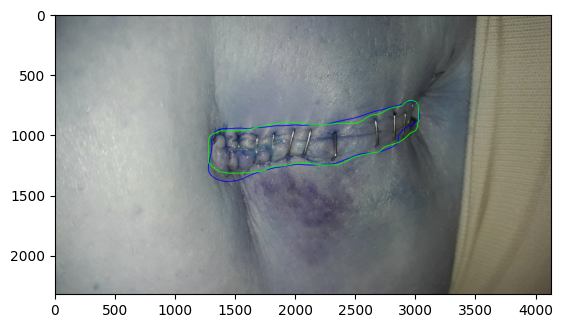

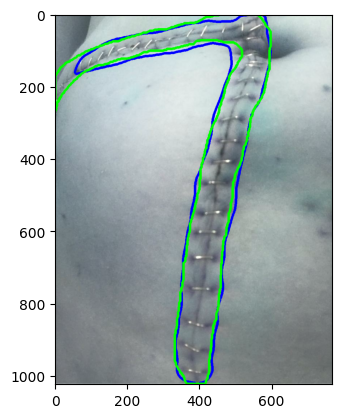

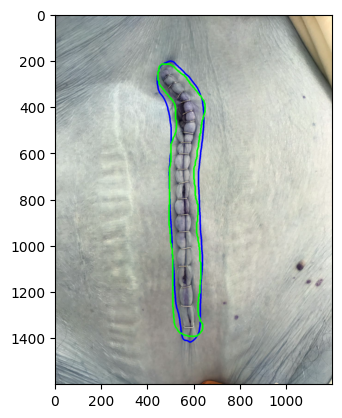

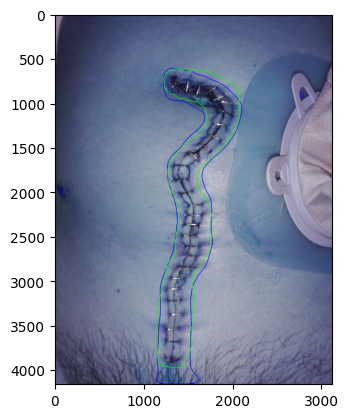

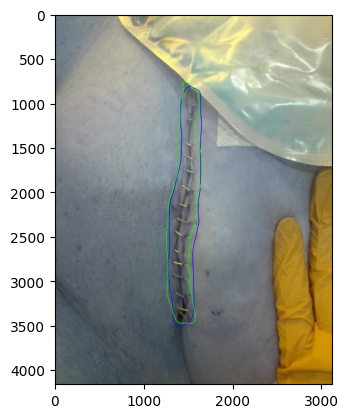

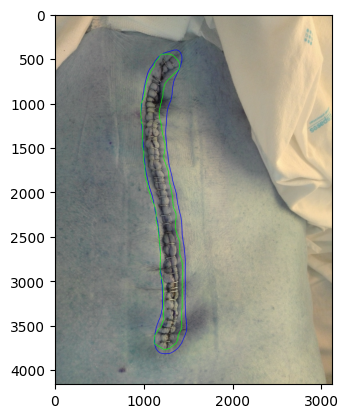

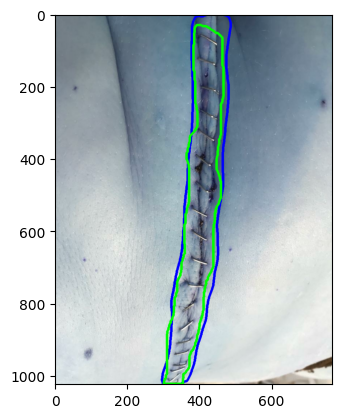

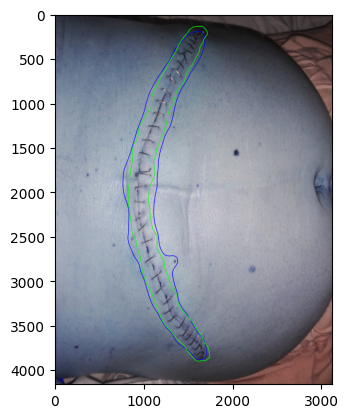

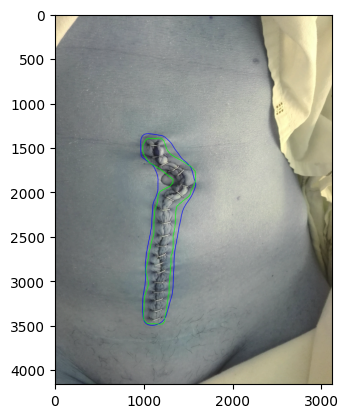

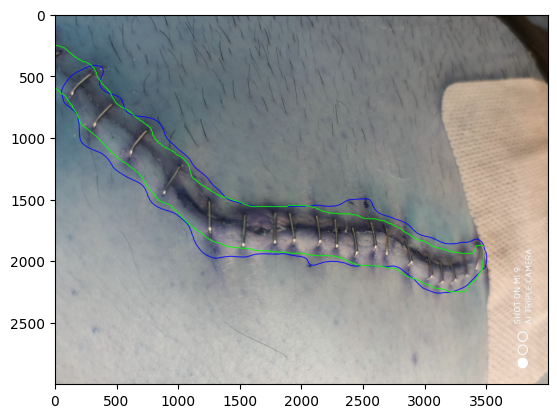

In [17]:
REDSCAR_DATASET = "/home/marc/UIB_EXPERIMENTS/REDSCAR"
REDSCAR_DATASET_TEST = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "test")
ruta_imatges= os.path.join(REDSCAR_DATASET_TEST,'IMAGES')
ruta_gts = os.path.join(REDSCAR_DATASET_TEST,'GT_WOUND_MASK')

ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/alta_resolucio_10_millors'

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatges, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_millors, titol="millor", qualitat=1)


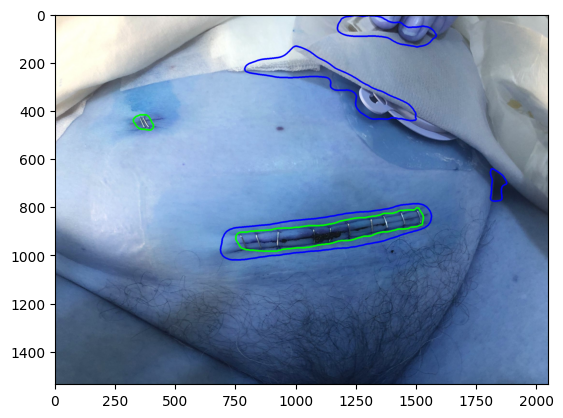

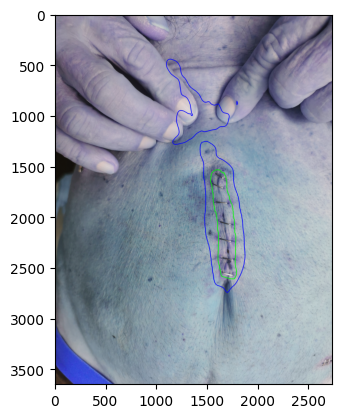

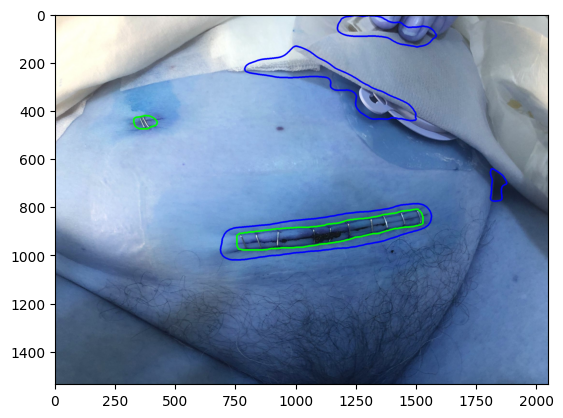

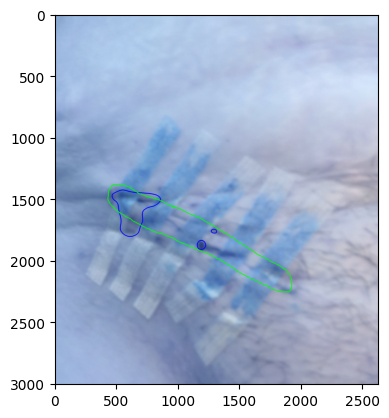

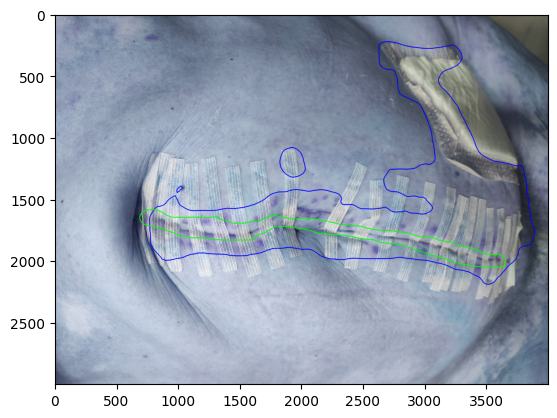

In [18]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/alta_resolucio_5_pitjors'

# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatges, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=1)


## Filtratge 2: millors i pitjors imatges de baixa resolució

In [19]:
# carregam el data frame de test:
#import pandas as pd
#df = pd.read_csv('/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/doubleunet_ferides_test.csv')

# filtram les imatges d'alta resolució -> df2
df2 = df[df['NOM'].str.endswith('resolution=0.png')]

# l'ordenam en funció del coeficient dice
df2_sorted = df2.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar
# guardarem també a un fitxer els noms de les imatges i els coeficients
print(df2_sorted)

                                                  NOM      DICE   JACCARD  \
0   cPYhmZcbJwrTse9ivAwswH3aR_infection=0_capture=...  0.922011  0.855307   
1   B130dg1MOeVf1euZ7ScuyO7JQ_infection=0_capture=...  0.910658  0.835971   
2   xIUmdHjGarh1OLf59VEYPVWKw_infection=0_capture=...  0.906463  0.828928   
3   0SeVHyRODnGrnAURdi8tbneiS_infection=0_capture=...  0.886184  0.795629   
4   DLrZ1c1Vs3L2b58XB1VXPPS01_infection=0_capture=...  0.854132  0.745401   
5   zwQi9HjWTK8ysQiJQcoOVPsLX_infection=0_capture=...  0.852090  0.742297   
6   7PsK2pKVrkofRQKGB6yIyAmqv_infection=0_capture=...  0.841885  0.726944   
7   BZRfauEFD4u1EBgg5mwHng2N4_infection=0_capture=...  0.840452  0.724810   
8   oedJksR9vFzg5fybwB07HlNyY_infection=0_capture=...  0.814616  0.687217   
9   bY4zWtNYXKhaPtnFwqWasgLax_infection=0_capture=...  0.804653  0.673155   
10  2XKzbg86QY1lzFzF6xyk8r49M_infection=0_capture=...  0.801900  0.669310   
11  XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=...  0.800978  0.668026   

In [20]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df2_sorted.loc[i,"NOM"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df2_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df2_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df2_sorted.loc[i,"NOM"]
    dice_value = df2_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_doubleunet_baixa = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/doubleunet_ferides_resultats_baixa.csv'
resultats_doubleunet_baixa.to_csv(RESULTATS_PATH, index=False)


['cPYhmZcbJwrTse9ivAwswH3aR_infection=0_capture=1_resolution=0.png', 'B130dg1MOeVf1euZ7ScuyO7JQ_infection=0_capture=1_resolution=0.png', 'xIUmdHjGarh1OLf59VEYPVWKw_infection=0_capture=1_resolution=0.png', '0SeVHyRODnGrnAURdi8tbneiS_infection=0_capture=1_resolution=0.png', 'DLrZ1c1Vs3L2b58XB1VXPPS01_infection=0_capture=1_resolution=0.png', 'zwQi9HjWTK8ysQiJQcoOVPsLX_infection=0_capture=1_resolution=0.png', '7PsK2pKVrkofRQKGB6yIyAmqv_infection=0_capture=1_resolution=0.png', 'BZRfauEFD4u1EBgg5mwHng2N4_infection=0_capture=1_resolution=0.png', 'oedJksR9vFzg5fybwB07HlNyY_infection=0_capture=1_resolution=0.png', 'bY4zWtNYXKhaPtnFwqWasgLax_infection=0_capture=1_resolution=0.png']
['cPYhmZcbJwrTse9ivAwswH3aR_infection=0_capture=1_resolution=0.png', 'B130dg1MOeVf1euZ7ScuyO7JQ_infection=0_capture=1_resolution=0.png', 'xIUmdHjGarh1OLf59VEYPVWKw_infection=0_capture=1_resolution=0.png', '0SeVHyRODnGrnAURdi8tbneiS_infection=0_capture=1_resolution=0.png', 'DLrZ1c1Vs3L2b58XB1VXPPS01_infection=0_capture

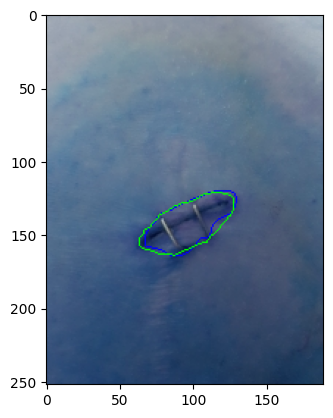

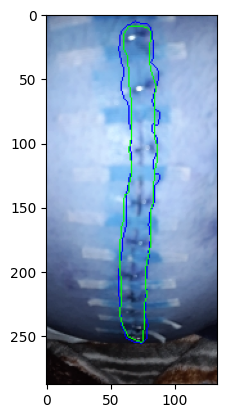

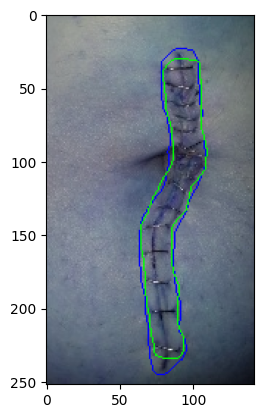

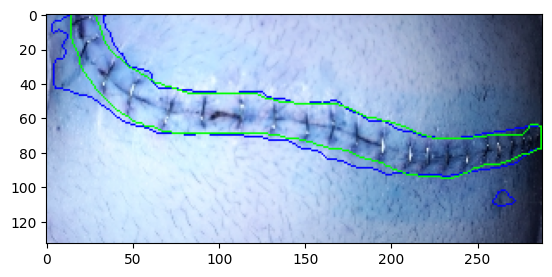

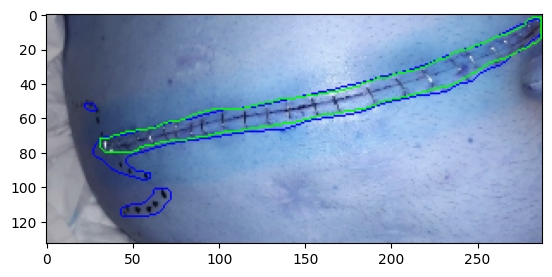

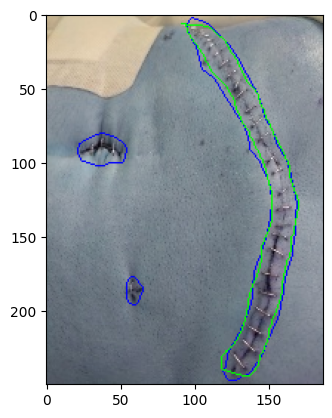

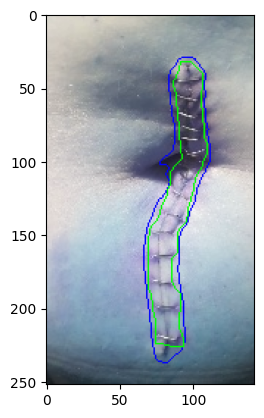

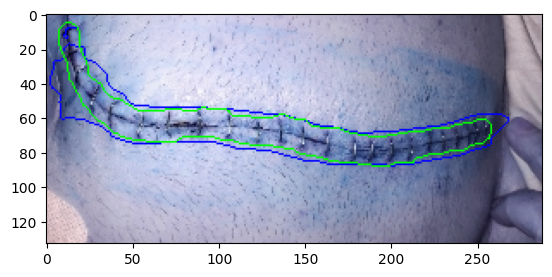

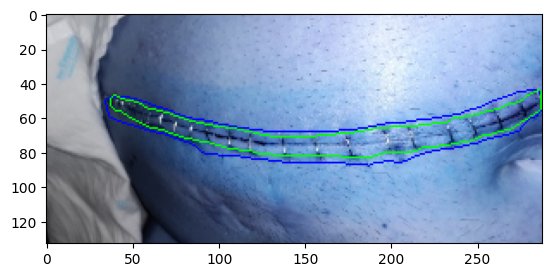

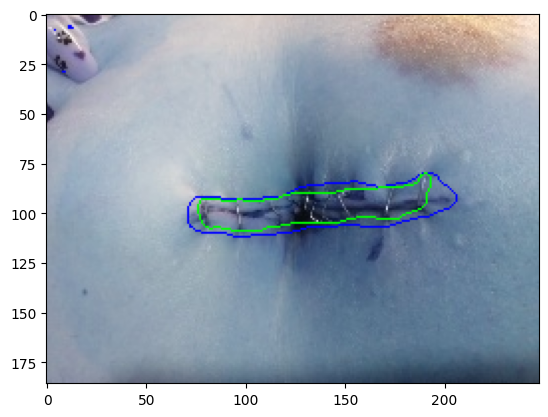

In [21]:
ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/baixa_resolucio_10_millors'

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatges, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_millors, titol="millor", qualitat=0)


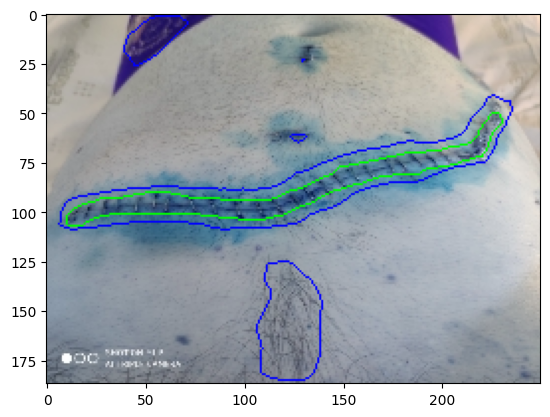

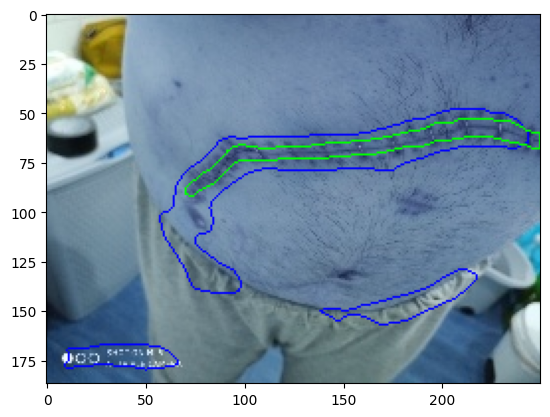

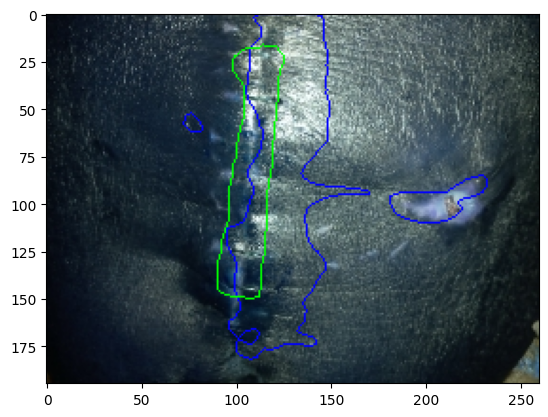

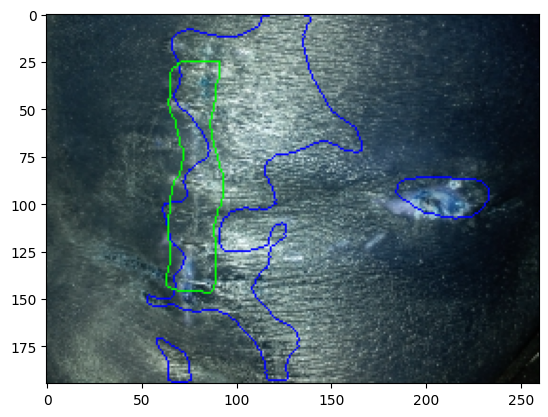

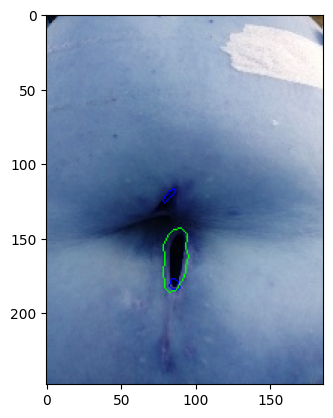

In [23]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/baixa_resolucio_5_pitjors'


# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatges, ruta_gt=ruta_gts, input_size=256, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=0)


In [11]:
REDSCAR_DATASET = "/home/marc/UIB_EXPERIMENTS/REDSCAR"
REDSCAR_DATASET_TEST = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "test")
ruta_imatges = os.path.join(REDSCAR_DATASET_TEST,'IMAGES')
ruta_gt_f = os.path.join(REDSCAR_DATASET_TEST,'GT_WOUND_MASK')
ruta_gt_g = os.path.join(REDSCAR_DATASET_TEST,'GT_STAPLES_MASK')
rutes_gt = [ruta_gt_f, ruta_gt_g]

nom = '2FrdqfR9OA980pwauusQZJ3Th_infection=0_capture=0_resolution=1.png'
original = cv2.imread(os.path.join(ruta_imatges, nom), 1)
gt_f = cv2.imread(os.path.join(rutes_gt[0], nom), 0) # escala de grisos
gt_g = cv2.imread(os.path.join(rutes_gt[1], nom), 0) # escala de grisos
prediccio_f = predict_image(model=loaded_model, model_input=(256, 256), image=original)

ruta_guardar = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment15/alta_resolucio_10_millors'

imatge_f = contorns(original, prediccio_f, gt_f, 1)
cv2.imwrite(ruta_guardar+rf"/dunet2_f.png", imatge_f)


True